In [14]:
#Using the same in-class implementation program for the assignment-7.
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

####1. Import Packages

####2. Download Data
<a href='https://pytorch.org/tutorials/beginner/basics/data_tutorial.html'>https://pytorch.org/tutorials/beginner/basics/data_tutorial.html</a>

In [15]:
# train_data=datasets.FashionMNIST(root="data",train=True,download=True,transform=ToTensor())
# test_data=datasets.FashionMNIST(root="data",train=False,download=True,transform=ToTensor())

#Load the dataset using torchvision.datasets.CIFAR100.
#https://pytorch.org/vision/stable/datasets.html#cifar

train_data = datasets.CIFAR100(root="data",train=True,download=True,transform=ToTensor())
test_data = datasets.CIFAR100(root="data",train=False,download=True,transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


####3. Load Datasets
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders

<p>
The `Dataset` retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in `minibatches`, reshuffle the data at every epoch to reduce model overfitting, and use Python’s `multiprocessing` to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.
</p>

**DataLoader(dataset, batch_size, shuffle)**
- dataset: the dataset itself <br>
- batch_size: number of samples we want to pass into the training loop at each iteration <br>
- shuffle: optionally we can opt to shuffle the data during each epoch <br>

   
```
from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
```

In [16]:
#working with batches
batch_size=128
train_dataloader=DataLoader(train_data,batch_size=batch_size)
test_dataloader=DataLoader(test_data,batch_size=batch_size)
print(len(train_dataloader))

# print(len(train_dataloader), 128*469) #60000
# print(len(test_dataloader), 128*79) #10000


391


####4. Load One Batch of Training data

In [17]:
for data in train_dataloader:
  break
  len(data)

X=data[0]
y=data[1]

print('Shape of X[B,C,H,W]:', X.shape)
print('Shape of y:', y.shape)

Shape of X[B,C,H,W]: torch.Size([128, 3, 32, 32])
Shape of y: torch.Size([128])


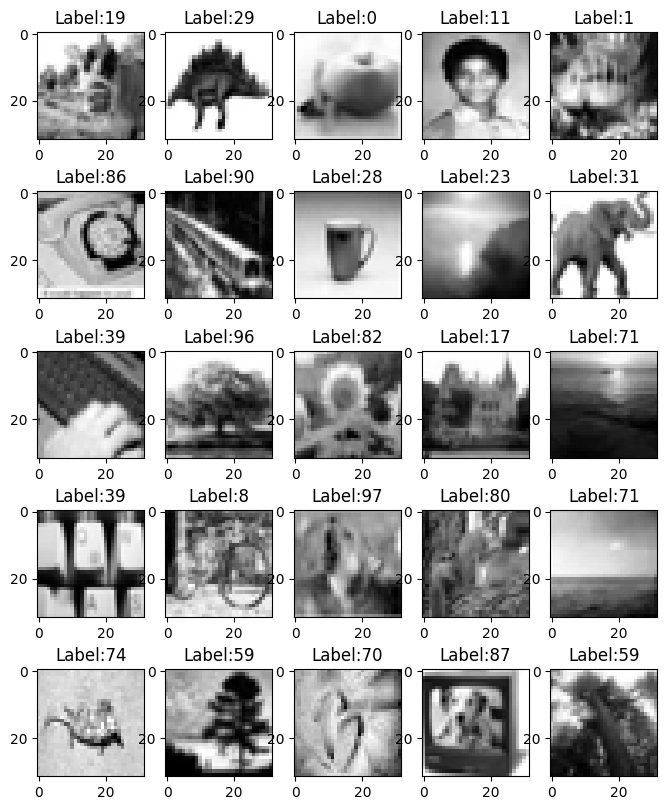

In [18]:
plt.figure(figsize=(8,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(X[i,0,:,:],cmap='gray')
  plt.title('Label:%d'%y[i])

####5. Neural Network
Torch.nn.Flatten()<br>
https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html<br>
torch.nn.Flatten(start_dim=1, end_dim=- 1) <br>
For Dimension, refer to https://towardsdatascience.com/understanding-dimensions-in-pytorch-6edf9972d3be <br>

**Torch.nn.Sequential**: https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html <br>
A sequential container. Modules will be added to it in the order they are passed in the constructor.

**Torch.nn.Linear**: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html <br>
`torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)`<br>
Applies a linear transformation to the incoming data: y=x$A^T$+b

**Torch.nn.ReLU**: https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html <br>
`torch.nn.ReLU(inplace=False)`<br>
ReLU(x)=(x)$^+$=max(0,x)

- Define MLP Model
- The model will have three layers
- input layer shape: 28*28*1
- Hidden layer shape: 512
- Output layer shape: 10

In [41]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP,self).__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(32*32*3, 512), # Changed the Value to 1024
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, 100))


  def forward(self,x):
    x=self.flatten(x)
    logits=self.linear_relu_stack(x)
    return logits

####6. Get CPU or GPU for training

In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Using %s device' %device)

model = MLP().to(device)
print(model)

Using cpu device
MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=512, out_features=100, bias=True)
  )
)


####7. Define the training and testing operation

Define the training operation
- Normally, we will train an NN in multiple epochs
  - Epoch: the model sees the entire training data once
- for training, we need:
  - NN model
  - loss function(cost)
  - optimizer(e.g., gradient descent)
- Tasks for one training step(i.e.,batch)
  - load one batch
  - pass the batch through the model
  - get model output
  - compute the cost(i.e., loss or prediction error)
  - backpropagation to update all the weight

In [43]:
def train(dataLoader, model, loss_fn, optimizer, device):
    model.train()

    for step, (X, y) in enumerate(dataLoader):
        X, y = X.to(device), y.to(device)

        pred = model(X)

        loss = loss_fn(pred, y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if step % 100 == 0:
            loss = loss.item()
            print('current step: %d. loss: %.4f' % (step, loss))


In [49]:
from logging import logProcesses

def test(dataloader,model,loss_fn,device):
  model.eval()
  num_batches=len(dataloader)
  test_loss=0
  correct=0

  all_pred_labels = []
  all_true_labels = []

  with torch.no_grad():
    # Iterate over the batches in the data loader
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)

        # Forward pass: compute predictions
        pred = model(X)
        pred_labels = pred.argmax(1).cpu().numpy()

        all_pred_labels.extend(pred_labels)
        all_true_labels.extend(y.cpu().numpy())

    # Calculate F1 score
    f1 = calculate_f1_score(all_pred_labels, all_true_labels)
    print("Test F1 Score: %.4f" % f1)

# Define the F1 score calculation function
def calculate_f1_score(pred_labels, true_labels):

    f1 = f1_score(true_labels, pred_labels, average='macro')
    return f1

####8. Optimizing the model parameter
- Train model in epoch


In [ ]:
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(),lr=1e-3)
loss_fn   = nn.CrossEntropyLoss()
#Adam typically requires less manual tuning of hyperparameters compared to SGD and often converges faster, making it a popular choice for training neural networks.
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)


epochs=20 # Tried with 20 , 10, 5
for t in tqdm.tqdm(range(epochs)):
  print('----------------Epoch:%d\n-------------------'%t)
  train(train_dataloader, model, loss_fn, optimizer, device)
  test(test_dataloader, model, loss_fn, device)

print("Done!")

  0%|          | 0/20 [00:00<?, ?it/s]

----------------Epoch:0
-------------------
current step: 0. loss: 2.7997
current step: 100. loss: 2.7427
current step: 200. loss: 2.4964
current step: 300. loss: 2.7051


  5%|▌         | 1/20 [00:16<05:07, 16.17s/it]

Test F1 Score: 0.2290
----------------Epoch:1
-------------------
current step: 0. loss: 2.6290
current step: 100. loss: 2.6083
current step: 200. loss: 2.4395
current step: 300. loss: 2.6811


 10%|█         | 2/20 [00:32<04:53, 16.32s/it]

Test F1 Score: 0.2223
----------------Epoch:2
-------------------
current step: 0. loss: 2.6422
current step: 100. loss: 2.6179
current step: 200. loss: 2.4181
current step: 300. loss: 2.4965


 15%|█▌        | 3/20 [00:52<05:01, 17.75s/it]

Test F1 Score: 0.2262
----------------Epoch:3
-------------------
current step: 0. loss: 2.4843
current step: 100. loss: 2.6198
current step: 200. loss: 2.3747
current step: 300. loss: 2.6245


 20%|██        | 4/20 [01:10<04:51, 18.20s/it]

Test F1 Score: 0.2271
----------------Epoch:4
-------------------
current step: 0. loss: 2.5171
current step: 100. loss: 2.5467
current step: 200. loss: 2.4594
current step: 300. loss: 2.3972


 25%|██▌       | 5/20 [01:30<04:39, 18.63s/it]

Test F1 Score: 0.2303
----------------Epoch:5
-------------------
current step: 0. loss: 2.3974
current step: 100. loss: 2.5982
current step: 200. loss: 2.4129
current step: 300. loss: 2.3342


 30%|███       | 6/20 [01:46<04:08, 17.78s/it]

Test F1 Score: 0.2331
----------------Epoch:6
-------------------
current step: 0. loss: 2.3970
current step: 100. loss: 2.4749
current step: 200. loss: 2.3574
current step: 300. loss: 2.2795


####9. Visualize testing result

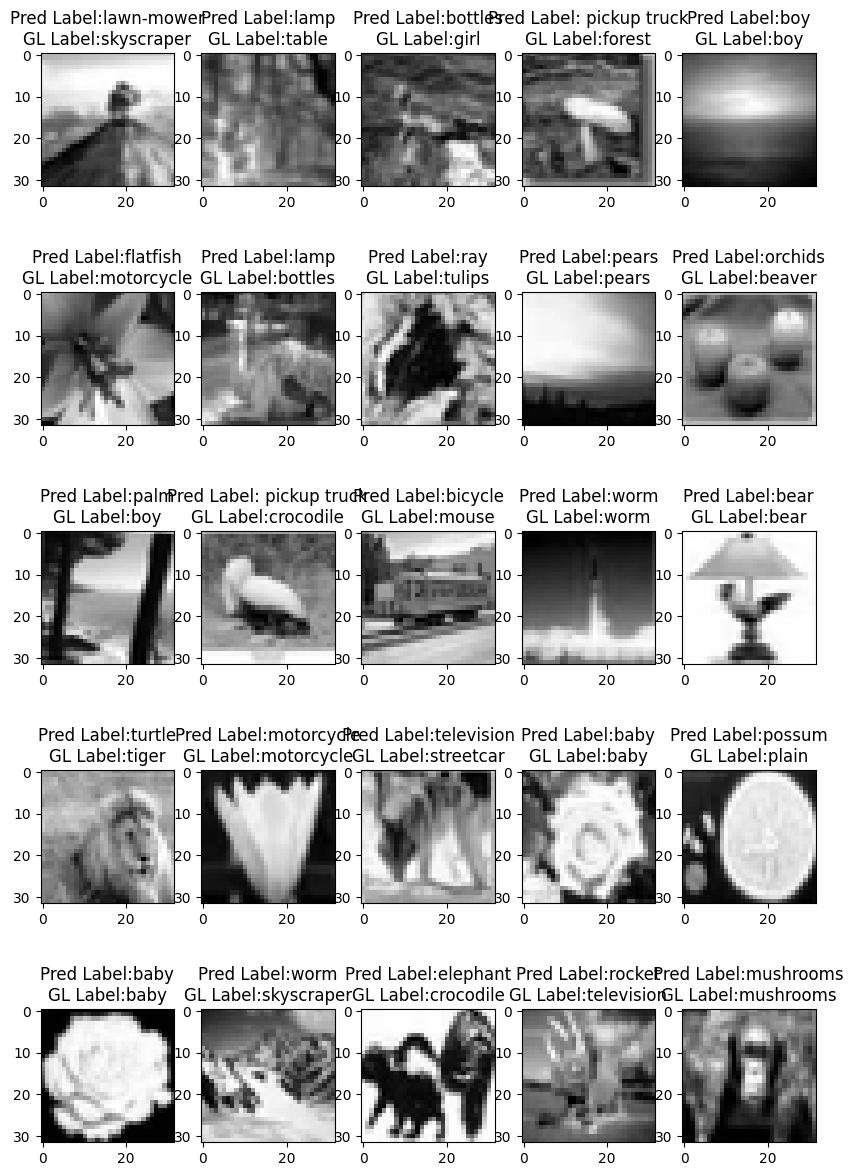

In [53]:
#classes contains the list of class labels corresponding to the CIFAR-100 dataset.
classes = ['beaver', 'dolphin', 'otter', 'seal', 'whale',	'aquarium fish', 'flatfish', 'ray', 'shark', 'trout',	'orchids', 'poppies', 'roses', 'sunflowers', 'tulips','bottles', 'bowls', 'cans', 'cups', 'plates',	'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers',
           'clock', 'computer keyboard', 'lamp', 'telephone', 'television', 'bed', 'chair', 'couch', 'table', 'wardrobe','bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach','bear', 'leopard', 'lion', 'tiger', 'wolf',
           'bridge', 'castle', 'house', 'road', 'skyscraper', 'cloud', 'forest', 'mountain', 'plain', 'sea', 'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo',	'fox', 'porcupine', 'possum', 'raccoon', 'skunk',
           'crab', 'lobster', 'snail', 'spider', 'worm', 'baby', 'boy', 'girl', 'man', 'woman', 'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle', 'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel',
           'maple', 'oak', 'palm', 'pine', 'willow', 'bicycle', 'bus', 'motorcycle',' pickup truck', 'train', 'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor']

model.eval()
for X,y in test_dataloader:
  X = X.to(device)
  y = y.to(device)
  with torch.no_grad():
    pred = model(X)
    pred_labels = pred.argmax(1)
  break
plt.figure(figsize=(10,15))
for i in range(25):
  y_hat = pred_labels[i].item()
  y_gt = y[i].item()
  plt.subplot(5,5,i+1)
  plt.imshow(X[i,0,:,:].cpu().numpy(),cmap='gray')
  plt.title('Pred Label:%s\nGL Label:%s' %(classes[y_hat],classes[y_gt]))